## Text Classification with Keras

In [1]:
import warnings

warnings.filterwarnings("ignore")

import random
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import kr_helper_funcs as kru
from cl_options import TrainingArgsParser

In [2]:
SEED = kru.seed_all()
print(f"Seeing with {SEED}")
print(f"Using Tensorflow {tf.__version__}")

MODEL_SAVE_PATH = pathlib.Path(os.getcwd()).parent / "model_states" / "kr_text_classification.pkl"
print(f"MODEL_SAVE_PATH -> {MODEL_SAVE_PATH}")

Seeing with 3441704331
Using Tensorflow 2.13.0
MODEL_SAVE_PATH -> /home/mjbhobe/code/git-projects/dl-keras/model_states/kr_text_classification.pkl


In [3]:
DATASET_BASE_PATH = pathlib.Path(os.getcwd()).parent / "tf2" / "datasets" / "sentiment_labelled_sentences"

dataset_paths = {
    "yelp": DATASET_BASE_PATH / "yelp_labelled.txt",
    "amazon": DATASET_BASE_PATH / "amazon_cells_labelled.txt",
    "imdb": DATASET_BASE_PATH / "imdb_labelled.txt",
}

df_list = []
for source, filepath in dataset_paths.items():
    df = pd.read_csv(str(filepath), names=["sentence", "label"], sep="\t")
    df["source"] = source
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


In [4]:
# let's see how sklearn's CountVectorizer helps us build a vocab
from sklearn.feature_extraction.text import CountVectorizer

sentences = ["John likes ice cream!", "John hates chocolate."]
vectorizer = CountVectorizer(min_df=0.0, lowercase=False)
vectorizer.fit(sentences)
vectorizer.vocabulary_

{'John': 0, 'likes': 5, 'ice': 4, 'cream': 2, 'hates': 3, 'chocolate': 1}

In [5]:
# this is also called bag-of-words technique
vectorizer.transform(sentences).toarray()

array([[1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0]])

Now let's do this on our corpus

In [6]:
sentences = df["sentence"].values
labels = df["label"].values
sentences[:5], labels[:5]

(array(['Wow... Loved this place.', 'Crust is not good.', 'Not tasty and the texture was just nasty.', 'Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.', 'The selection on the menu was great and so were the prices.'], dtype=object),
 array([1, 0, 0, 1, 1]))

Create the train & test datasets for model training

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    sentences,
    labels,
    test_size=0.25,
    random_state=SEED,
)
print(
    f"X_train.shape: {X_train.shape} - y_train.shape: {y_train.shape} - "
    f"X_test.shape: {X_test.shape} - y_test.shape: {y_test.shape}"
)

X_train.shape: (2061,) - y_train.shape: (2061,) - X_test.shape: (687,) - y_test.shape: (687,)


In [22]:
# and we will vectorize the data
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
print(
    f"X_train.shape: {X_train.shape} - y_train.shape: {y_train.shape} - "
    f"X_test.shape: {X_test.shape} - y_test.shape: {y_test.shape}"
)

(<1x4245 sparse matrix of type '<class 'numpy.int64'>'
 	with 5 stored elements in Compressed Sparse Row format>,
 <1x4245 sparse matrix of type '<class 'numpy.int64'>'
 	with 9 stored elements in Compressed Sparse Row format>)

### Base `LogisticRegression` model

In [30]:
# base classification model
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print(f"LogisticRegression (base model) acc: {score:.3f}")

LogisticRegression (base model) acc: 0.801


### Building Deep Learning model with Keras

In [31]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [34]:
input_dim = X_train.shape[1]

model = Sequential(
    [
        Dense(10, activation="relu", input_dim=input_dim),
        Dense(1, activation="sigmoid"),
    ]
)
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                42460     
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 42471 (165.90 KB)
Trainable params: 42471 (165.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [37]:
hist = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=10,
    validation_data=(X_test, y_test),
    verbose=2,
)

Epoch 1/100
207/207 - 1s - loss: 0.0109 - accuracy: 0.9981 - val_loss: 0.6057 - val_accuracy: 0.8006 - 1s/epoch - 7ms/step
Epoch 2/100
207/207 - 1s - loss: 0.0097 - accuracy: 0.9981 - val_loss: 0.6140 - val_accuracy: 0.7991 - 845ms/epoch - 4ms/step
Epoch 3/100
207/207 - 1s - loss: 0.0087 - accuracy: 0.9981 - val_loss: 0.6232 - val_accuracy: 0.7962 - 850ms/epoch - 4ms/step
Epoch 4/100
207/207 - 1s - loss: 0.0080 - accuracy: 0.9981 - val_loss: 0.6550 - val_accuracy: 0.7948 - 817ms/epoch - 4ms/step
Epoch 5/100
207/207 - 1s - loss: 0.0071 - accuracy: 0.9981 - val_loss: 0.6816 - val_accuracy: 0.7948 - 823ms/epoch - 4ms/step
Epoch 6/100
207/207 - 1s - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.6921 - val_accuracy: 0.7948 - 832ms/epoch - 4ms/step
Epoch 7/100
207/207 - 1s - loss: 0.0059 - accuracy: 0.9981 - val_loss: 0.6871 - val_accuracy: 0.7977 - 852ms/epoch - 4ms/step
Epoch 8/100
207/207 - 1s - loss: 0.0054 - accuracy: 0.9981 - val_loss: 0.7066 - val_accuracy: 0.7977 - 832ms/epoch - 4ms/

['loss', 'accuracy']


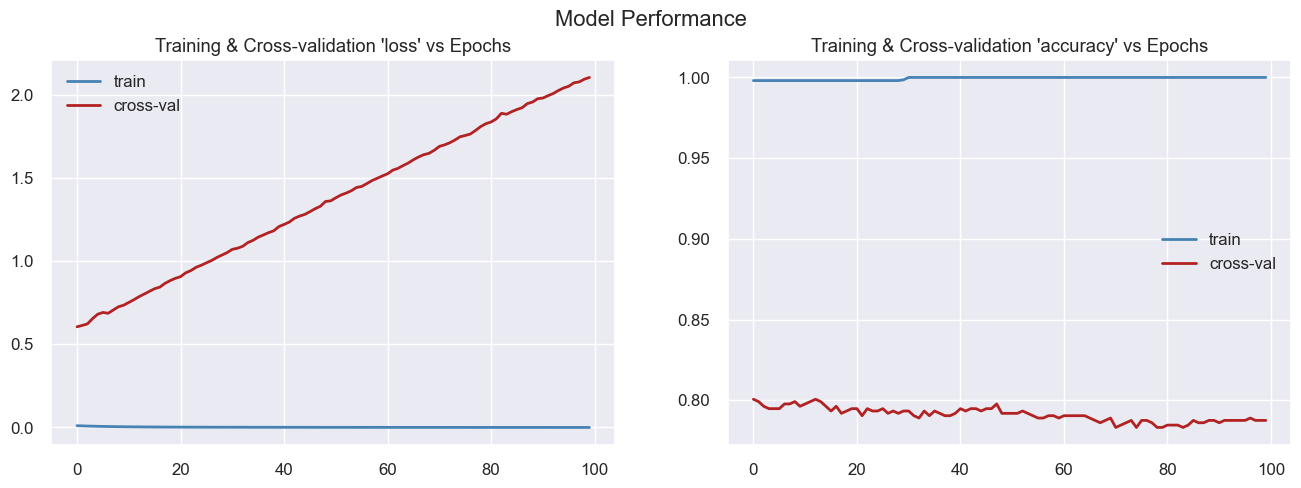

In [38]:
kru.plot_metrics(hist.history, title="Model Performance")

In [39]:
loss, acc = model.evaluate(X_train, y_train, verbose=False)
print(f"Train dataset -> loss: {loss:.3f} - acc: {acc:.3f}")
loss, acc = model.evaluate(X_test, y_test, verbose=False)
print(f"Test dataset -> loss: {loss:.3f} - acc: {acc:.3f}")

Train dataset -> loss: 0.000 - acc: 1.000
Test dataset -> loss: 2.106 - acc: 0.787
